<h2 align="center">Vehicle Damage Detection Project</h2>

In [57]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import time
import matplotlib.pyplot as plt

In [58]:
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

print("Using:", device)

Using: mps


### Load Data

In [59]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [60]:
dataset_path = "./dataset"
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [89]:
class_names = dataset.classes

In [62]:
num_classes = len(dataset.classes)
num_classes

6

In [63]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_size, val_size

(1725, 575)

In [64]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [65]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [66]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [67]:
labels[5]

tensor(2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


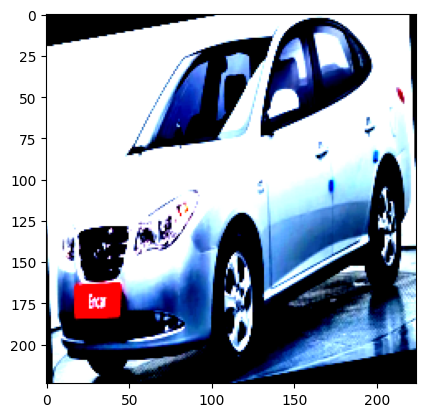

In [68]:
plt.imshow(images[5].permute(1, 2, 0))

In [69]:
len(train_dataset)

1725

In [70]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [71]:
# instantiate the Model , Loss function and optimizer

model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [72]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [75]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.21
Batch: 20, Epoch: 1, Loss: 1.15
Batch: 30, Epoch: 1, Loss: 1.20
Batch: 40, Epoch: 1, Loss: 0.97
Batch: 50, Epoch: 1, Loss: 1.29
Epoch [1/5], Avg Loss: 1.2095
*** Validation Accuracy: 48.35% ***
Batch: 10, Epoch: 2, Loss: 1.15
Batch: 20, Epoch: 2, Loss: 0.85
Batch: 30, Epoch: 2, Loss: 0.97
Batch: 40, Epoch: 2, Loss: 1.15
Batch: 50, Epoch: 2, Loss: 0.84
Epoch [2/5], Avg Loss: 1.1014
*** Validation Accuracy: 54.09% ***
Batch: 10, Epoch: 3, Loss: 0.97
Batch: 20, Epoch: 3, Loss: 0.77
Batch: 30, Epoch: 3, Loss: 1.11
Batch: 40, Epoch: 3, Loss: 0.62
Batch: 50, Epoch: 3, Loss: 0.81
Epoch [3/5], Avg Loss: 0.9782
*** Validation Accuracy: 56.52% ***
Batch: 10, Epoch: 4, Loss: 0.90
Batch: 20, Epoch: 4, Loss: 0.97
Batch: 30, Epoch: 4, Loss: 0.67
Batch: 40, Epoch: 4, Loss: 1.00
Batch: 50, Epoch: 4, Loss: 0.77
Epoch [4/5], Avg Loss: 0.8838
*** Validation Accuracy: 57.91% ***
Batch: 10, Epoch: 5, Loss: 0.72
Batch: 20, Epoch: 5, Loss: 0.70
Batch: 30, Epoch: 5, Loss: 1.03


### Model 2: CNN with Regularization

In [76]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [77]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [78]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 12.05
Batch: 20, Epoch: 1, Loss: 5.44
Batch: 30, Epoch: 1, Loss: 2.87
Batch: 40, Epoch: 1, Loss: 1.46
Batch: 50, Epoch: 1, Loss: 1.61
Epoch [1/10], Avg Loss: 7.6306
*** Validation Accuracy: 41.04% ***
Batch: 10, Epoch: 2, Loss: 1.37
Batch: 20, Epoch: 2, Loss: 1.37
Batch: 30, Epoch: 2, Loss: 1.54
Batch: 40, Epoch: 2, Loss: 1.37
Batch: 50, Epoch: 2, Loss: 1.86
Epoch [2/10], Avg Loss: 1.4879
*** Validation Accuracy: 41.57% ***
Batch: 10, Epoch: 3, Loss: 1.53
Batch: 20, Epoch: 3, Loss: 1.52
Batch: 30, Epoch: 3, Loss: 1.40
Batch: 40, Epoch: 3, Loss: 1.48
Batch: 50, Epoch: 3, Loss: 1.45
Epoch [3/10], Avg Loss: 1.4150
*** Validation Accuracy: 43.30% ***
Batch: 10, Epoch: 4, Loss: 1.40
Batch: 20, Epoch: 4, Loss: 1.51
Batch: 30, Epoch: 4, Loss: 1.24
Batch: 40, Epoch: 4, Loss: 1.14
Batch: 50, Epoch: 4, Loss: 1.23
Epoch [4/10], Avg Loss: 1.3284
*** Validation Accuracy: 48.17% ***
Batch: 10, Epoch: 5, Loss: 1.19
Batch: 20, Epoch: 5, Loss: 1.17
Batch: 30, Epoch: 5, Loss: 

### Model 3: Transfer Learning with EfficientNet

In [79]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [80]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [82]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.61
Batch: 20, Epoch: 1, Loss: 1.35
Batch: 30, Epoch: 1, Loss: 1.41
Batch: 40, Epoch: 1, Loss: 1.22
Batch: 50, Epoch: 1, Loss: 1.17
Epoch [1/10], Avg Loss: 1.4616
*** Validation Accuracy: 59.48% ***
Batch: 10, Epoch: 2, Loss: 1.13
Batch: 20, Epoch: 2, Loss: 1.03
Batch: 30, Epoch: 2, Loss: 1.18
Batch: 40, Epoch: 2, Loss: 0.97
Batch: 50, Epoch: 2, Loss: 1.00
Epoch [2/10], Avg Loss: 1.1309
*** Validation Accuracy: 63.13% ***
Batch: 10, Epoch: 3, Loss: 1.07
Batch: 20, Epoch: 3, Loss: 1.06
Batch: 30, Epoch: 3, Loss: 0.92
Batch: 40, Epoch: 3, Loss: 1.06
Batch: 50, Epoch: 3, Loss: 1.12
Epoch [3/10], Avg Loss: 1.0096
*** Validation Accuracy: 64.87% ***
Batch: 10, Epoch: 4, Loss: 0.96
Batch: 20, Epoch: 4, Loss: 0.90
Batch: 30, Epoch: 4, Loss: 0.79
Batch: 40, Epoch: 4, Loss: 0.75
Batch: 50, Epoch: 4, Loss: 0.75
Epoch [4/10], Avg Loss: 0.9388
*** Validation Accuracy: 66.96% ***
Batch: 10, Epoch: 5, Loss: 1.16
Batch: 20, Epoch: 5, Loss: 0.80
Batch: 30, Epoch: 5, Loss: 0

### Model 4: Transfer Learning with ResNet

In [84]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [85]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/macbook/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|█████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:05<00:00, 17.4MB/s]


Batch: 10, Epoch: 1, Loss: 0.93
Batch: 20, Epoch: 1, Loss: 0.81
Batch: 30, Epoch: 1, Loss: 0.76
Batch: 40, Epoch: 1, Loss: 0.51
Batch: 50, Epoch: 1, Loss: 0.73
Epoch [1/10], Avg Loss: 0.8788
*** Validation Accuracy: 76.17% ***
Batch: 10, Epoch: 2, Loss: 0.40
Batch: 20, Epoch: 2, Loss: 0.41
Batch: 30, Epoch: 2, Loss: 0.26
Batch: 40, Epoch: 2, Loss: 0.39
Batch: 50, Epoch: 2, Loss: 0.57
Epoch [2/10], Avg Loss: 0.4672
*** Validation Accuracy: 75.83% ***
Batch: 10, Epoch: 3, Loss: 0.36
Batch: 20, Epoch: 3, Loss: 0.13
Batch: 30, Epoch: 3, Loss: 0.14
Batch: 40, Epoch: 3, Loss: 0.50
Batch: 50, Epoch: 3, Loss: 0.56
Epoch [3/10], Avg Loss: 0.3472
*** Validation Accuracy: 74.96% ***
Batch: 10, Epoch: 4, Loss: 0.26
Batch: 20, Epoch: 4, Loss: 0.12
Batch: 30, Epoch: 4, Loss: 0.22
Batch: 40, Epoch: 4, Loss: 0.57
Batch: 50, Epoch: 4, Loss: 0.19
Epoch [4/10], Avg Loss: 0.2440
*** Validation Accuracy: 76.70% ***
Batch: 10, Epoch: 5, Loss: 0.12
Batch: 20, Epoch: 5, Loss: 0.21
Batch: 30, Epoch: 5, Loss: 0

#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

So now let's train the model once again with these best parameters

In [86]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 2.52
Batch: 20, Epoch: 1, Loss: 0.72
Batch: 30, Epoch: 1, Loss: 0.67
Batch: 40, Epoch: 1, Loss: 0.79
Batch: 50, Epoch: 1, Loss: 0.54
Epoch [1/10], Avg Loss: 0.9274
*** Validation Accuracy: 72.70% ***
Batch: 10, Epoch: 2, Loss: 0.91
Batch: 20, Epoch: 2, Loss: 0.37
Batch: 30, Epoch: 2, Loss: 0.47
Batch: 40, Epoch: 2, Loss: 0.32
Batch: 50, Epoch: 2, Loss: 0.35
Epoch [2/10], Avg Loss: 0.5305
*** Validation Accuracy: 75.65% ***
Batch: 10, Epoch: 3, Loss: 0.44
Batch: 20, Epoch: 3, Loss: 0.36
Batch: 30, Epoch: 3, Loss: 0.27
Batch: 40, Epoch: 3, Loss: 0.59
Batch: 50, Epoch: 3, Loss: 0.26
Epoch [3/10], Avg Loss: 0.3791
*** Validation Accuracy: 76.00% ***
Batch: 10, Epoch: 4, Loss: 0.23
Batch: 20, Epoch: 4, Loss: 0.37
Batch: 30, Epoch: 4, Loss: 0.20
Batch: 40, Epoch: 4, Loss: 0.56
Batch: 50, Epoch: 4, Loss: 0.38
Epoch [4/10], Avg Loss: 0.3053
*** Validation Accuracy: 79.30% ***
Batch: 10, Epoch: 5, Loss: 0.34
Batch: 20, Epoch: 5, Loss: 0.20
Batch: 30, Epoch: 5, Loss: 0

### Model Evaluation using Confusion Matrix and Classification Report